# MLSys_Project_Phase1

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 34.5 MB/s eta 0:00:00


In [2]:
# needed libraries

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
from os import listdir
import glob
import skimage.io as io
import skimage.transform as trans

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## DATA

Data is accessible by this link https://drive.google.com/drive/folders/1_2QyBKt1xKD3TPRu7V9TRYGEbCODeeor?usp=sharing

In [4]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image

# Load the dataset
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/data'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

def load_data(data_folder):
    all_images = []
    all_labels = []
    for foldername in os.listdir(data_folder):
        if foldername == 'image':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            all_images.append(image_path)
        elif foldername == 'label':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            all_labels.append(image_path)

    return np.array(all_images), np.array(all_labels)

# Combine the images
train_images, train_labels = load_data(train_dir)

# Count the number of data in each class
print("Number of Train Images: ", len(train_images))

Number of Train Images:  30


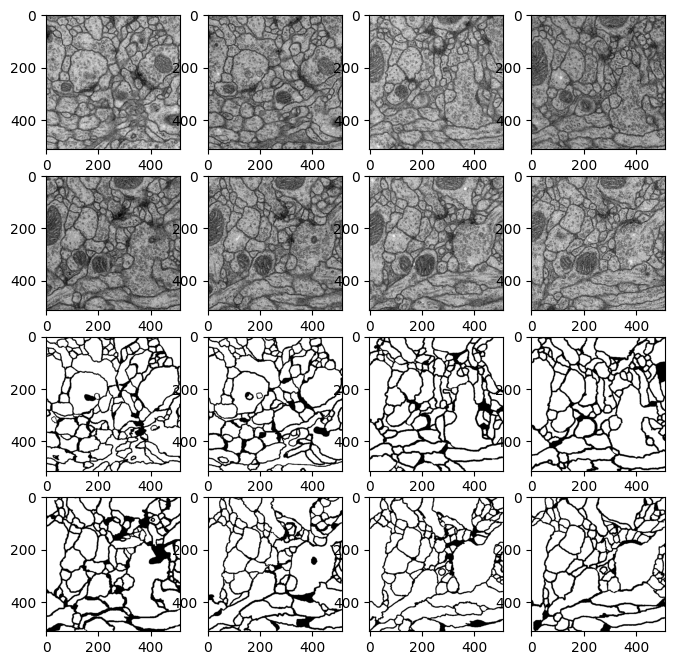

In [5]:
import matplotlib.pyplot as plt

num_images_to_show = 16
dimensions = []
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(int(num_images_to_show/2)):
  random_number = random.randint(0, len(train_images))
  image_path = train_images[i]
  mask_path = train_labels[i]
  img_1 = plt.imread(image_path)
  img_1 = Image.open(image_path).convert("RGB")
  img_1_data = np.asarray(img_1)
  img_2 = plt.imread(mask_path)
  img_2 = Image.open(mask_path).convert("RGB")
  img_2_data = np.asarray(img_2)

  row = i // 4
  col = i % 4
  ax[row, col].imshow(img_1_data)
  ax[row+2, col].imshow(img_2_data)

plt.show()

## Data preprocessing class

In [6]:
class image_preprocessing:


    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

    def __init__(self, train_path, test_path, augmented_path):
        self.train_path = train_path
        self.test_path = test_path
        self.augmented_path = augmented_path
        isExist = os.path.exists(self.augmented_path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(self.augmented_path)

    def adjustData(self, img,mask, flag_multi_class, num_class):
        if(flag_multi_class):
            img = img / 255
            mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
            new_mask = np.zeros(mask.shape + (num_class,))
            for i in range(num_class):
                #for one pixel in the image, find the class in mask and convert it into one-hot vector
                new_mask[mask == i,i] = 1
            new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
            mask = new_mask
        elif(np.max(img) > 1):
            img = img / 255
            mask = mask /255
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
        return (img,mask)

    def trainGenerator(self, batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                       mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
                       flag_multi_class = False, num_class = 2, save_to_dir_image = None, save_to_dir_label = None, target_size = (256,256), seed = 1):

        '''
        can generate image and mask at the same time
        use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
        if you want to visualize the results of generator, set save_to_dir = "your path"
        '''
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
        image_generator = image_datagen.flow_from_directory(
            train_path,
            classes = [image_folder],
            class_mode = None,
            color_mode = image_color_mode,
            target_size = target_size,
            batch_size = batch_size,
            # save_to_dir = save_to_dir,
            save_to_dir = save_to_dir_image,
            save_prefix  = image_save_prefix,
            seed = seed)
        mask_generator = mask_datagen.flow_from_directory(
            train_path,
            classes = [mask_folder],
            class_mode = None,
            color_mode = mask_color_mode,
            target_size = target_size,
            batch_size = batch_size,
            # save_to_dir = save_to_dir,
            save_to_dir = save_to_dir_label,
            save_prefix  = mask_save_prefix,
            seed = seed)
        train_generator = zip(image_generator, mask_generator)
        for (img,mask) in train_generator:
            img,mask = self.adjustData(img,mask,flag_multi_class,num_class)
            yield (img,mask)

    def testGenerator(self, test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
      for i in range(num_image):
          img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          yield img


    def geneTrainNpy(image_path, mask_path, flag_multi_class = False, num_class = 2, image_prefix = "image",
                     mask_prefix = "mask", image_as_gray = True, mask_as_gray = True):
        image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
        image_arr = []
        mask_arr = []
        for index,item in enumerate(image_name_arr):
            img = io.imread(item,as_gray = image_as_gray)
            img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
            mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
            mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
            img, mask = self.adjustData(img, mask, flag_multi_class, num_class)
            image_arr.append(img)
            mask_arr.append(mask)
        image_arr = np.array(image_arr)
        mask_arr = np.array(mask_arr)
        return image_arr, mask_arr

    def labelVisualize(num_class, color_dict,img):
        img = img[:,:,0] if len(img.shape) == 3 else img
        img_out = np.zeros(img.shape + (3,))
        for i in range(num_class):
            img_out[img == i,:] = color_dict[i]
        return img_out / 255


    def saveResult(self, save_path, npyfile, flag_multi_class = False, num_class = 2):
        for i,item in enumerate(npyfile):
            img = self.labelVisualize(num_class,self.COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Running-Section

### defining data generator

In [7]:
# if you don't want to do data augmentation, set data_gen_args as an empty dict.
# data_gen_args = dict()

train_path = '/content/drive/My Drive/MLSys/Project_phase1&2/data/train'
test_path = '/content/drive/My Drive/MLSys/Project_phase1&2/data/test/image'
aug_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/"
aug_image_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/image/"
aug_label_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/label/"

ip = image_preprocessing(train_path, test_path, aug_path)

In [8]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     preprocessing_function=tfa.image.gaussian_filter2d,
                     fill_mode='nearest',
                    )

In [ ]:
myGenerator = ip.trainGenerator(20, train_path, 'image', 'label', data_gen_args, save_to_dir_image = aug_image_path, save_to_dir_label = aug_label_path)

### visualize data augmentation result

In [ ]:
# aftert this step we will see 60 transformed images and their masks in data/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

In [10]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image

# Load the dataset
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/'

def load_data(data_folder):
    all_images = []
    all_labels = []
    aug_folder_path = "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/label"
    for foldername in os.listdir(data_folder):
        if foldername == 'image':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            label_filename = filename.replace("image", "mask")
            image_path = os.path.join(folder_path, filename)
            label_path = os.path.join(aug_folder_path, label_filename)
            all_images.append(image_path)
            all_labels.append(label_path)

    return np.array(all_images), np.array(all_labels)

# Combine the images
aug_images, aug_labels = load_data(data_dir)

# Count the number of data in each class
print("Number of aug Images: ", len(aug_images))

Number of aug Images:  120


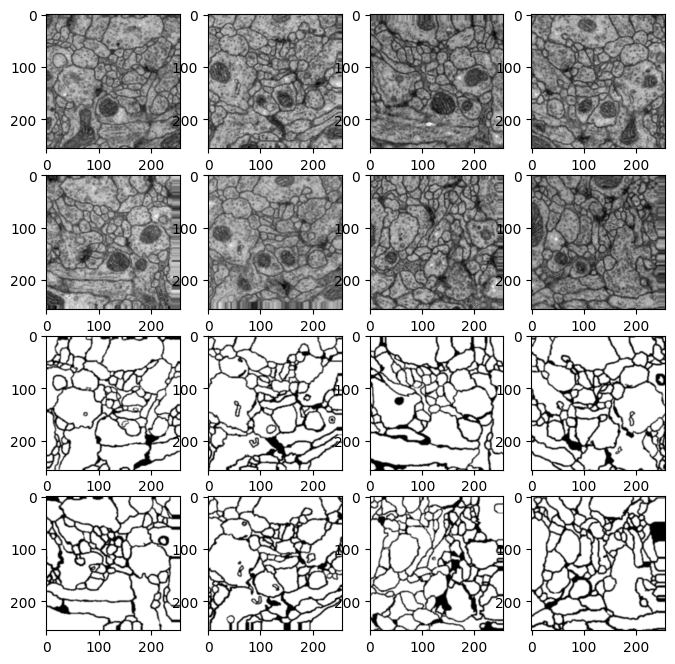

In [11]:
import matplotlib.pyplot as plt

num_images_to_show = 16
dimensions = []
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(int(num_images_to_show/2)):
  random_number = random.randint(0, len(aug_images))
  image_path = aug_images[i]
  mask_path = aug_labels[i]
  img_1 = plt.imread(image_path)
  img_1 = Image.open(image_path).convert("RGB")
  img_1_data = np.asarray(img_1)
  img_2 = plt.imread(mask_path)
  img_2 = Image.open(mask_path).convert("RGB")
  img_2_data = np.asarray(img_2)

  row = i // 4
  col = i % 4
  ax[row, col].imshow(img_1_data)
  ax[row+2, col].imshow(img_2_data)

plt.show()

### Transfer learning

In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

def transfer_learning(model, parent_path):
  # get the path/directory
  folder_dir = parent_path
  features = np.empty((30, 7, 7, 512), float)
  for images in os.listdir(folder_dir):
    # check if the image ends with png
    if (images.endswith(".png")):
      img_path = parent_path + images
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      np.append(features, model.predict(x), axis=0)

  return features

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = VGG16(weights='imagenet', include_top=False)
parent_path = train_path + '/image/'
features = transfer_learning(model, parent_path)
print(features.shape)

1/1 [==============================] - 0s 19ms/step
(30, 7, 7, 512)
